In [7]:
import sys
sys.path.insert(0, "..")
sys.path.insert(0, "../..")

import torch
from transformers.integrations.bitnet import unpack_weights, BitLinear, pack_weights
import timeit
from torch_impl.multipliers import *
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.ticker import LogLocator

In [2]:
device = torch.device("cuda")

### Implementation

In [3]:
def rsr_multiplication(vector, agg_matrix, k=2):
    v = vector.squeeze(0)
    vectors_expanded = v.unsqueeze(1).expand(-1, k, -1)
    result = torch.bmm(vectors_expanded.flatten(0, 1).unsqueeze(1), agg_matrix[:k*v.size(0)]).squeeze(1)
    result = result.view(v.size(0), k, -1)
    return torch.stack([result[:,j,:] for j in range(k)], dim=2).reshape(v.size(0), -1).unsqueeze(0)[:,:,:-k + (vector.size(2) % k)]

In [4]:
def standard_multiplication(vector, matrix):
    return vector @ matrix

### Run

In [ ]:
result = []

for i, log_n in enumerate([11, 12, 13, 14]):
    n = 2 ** log_n
    k = 2
    
    print(f"log_n: {log_n} | {i + 1} / {6}")
    
    matrix = torch.randint(-1, 2, (n, n)).to(dtype=torch.bfloat16).to(device) # bfloat16 is the type of quantized BitLinear
    vector = torch.rand((1, 2, n)).to(dtype=torch.bfloat16).to(device) # (1, 2, n) is the shape of an input vector in BitLinear

    # Preprocess and build final matrices
    mult = RSRTernaryMultiplier(matrix.to(torch.device("cpu")), k=k)
    c = mult.get_agg_matrix().to(device)
    cs = [c[:,:,j] for j in range(k)]
    ms = [x.T.contiguous() for x in cs]
    agg_matrices = torch.stack(ms, dim=0)
    del ms, cs, c
    agg_matrices = agg_matrices.unsqueeze(0).expand(k, -1, -1, -1).flatten(0, 1)
    
    # Verify
    assert torch.allclose(rsr_multiplication(vector, agg_matrices, k), standard_multiplication(vector, matrix), atol=1e-2, rtol=1e-2)
    
    time_rsr = %timeit -o rsr_multiplication(vector, agg_matrices, k)
    time_standard = %timeit -o standard_multiplication(vector, matrix)
    
    result.append({
        "RSR": time_rsr.average,
        "Standard": time_standard.average,
        "log_n": log_n
    })

In [6]:
result = pd.DataFrame(result)

In [6]:
result = pd.read_csv("matrix_mult_time_report.csv", index_col=False)
result.head()

,RSR,Standard,log_n
0,0.000107,0.000307,11
1,0.000288,0.000725,12
2,0.001191,0.001931,13
3,0.004628,0.007097,14


### Visualize

In [9]:
def set_sns_style():
    sns.set(font_scale=1.5)
    sns.set_style("whitegrid")

    plt.rcParams['font.family'] = 'serif'  # Set font to Times New Roman
    plt.rcParams['text.color'] = 'black'  # Set text color to black
    plt.rcParams['axes.labelcolor'] = 'black'  # Set axis labels color to black
    plt.rcParams['xtick.color'] = 'black'  # Set x-tick color to black
    plt.rcParams['ytick.color'] = 'black'  # Set y-tick color to black
    plt.rcParams['axes.edgecolor'] = 'black'  # Set axes edge color to black
    plt.rcParams['axes.titleweight'] = 'bold'  # Bold title for emphasis

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


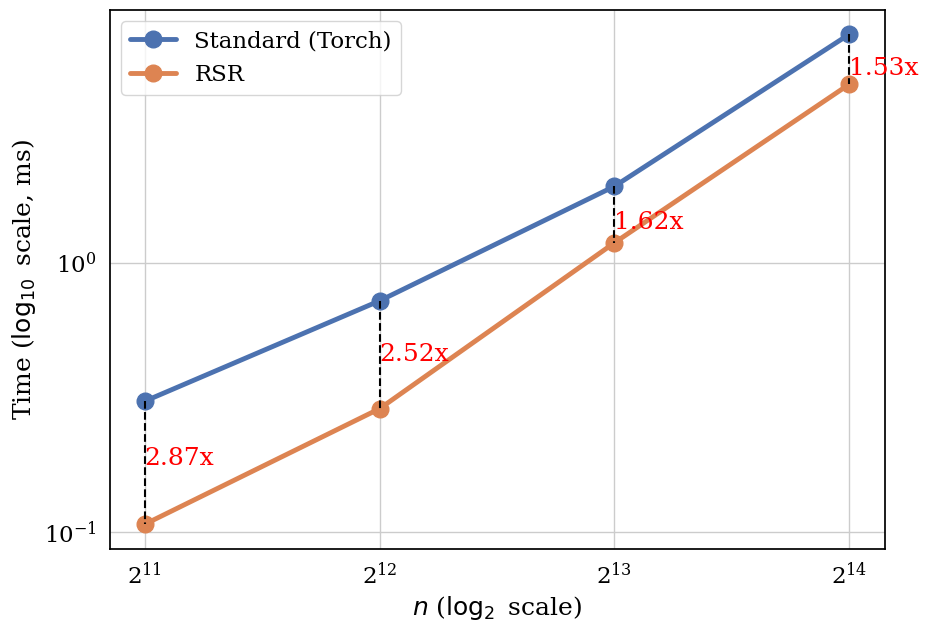

In [17]:
set_sns_style()

n = [2**11, 2**12, 2**13, 2**14]
standard = result['Standard'] * 1000
rsr = result['RSR'] * 1000

plt.figure(figsize=(10, 7))


# Plot times for NaiveMultiplier and RSRMultiplier
plt.plot(n, standard, label='Standard (Torch)', marker="o", linewidth=3.5, markersize=12)
plt.plot(n, rsr, label='RSR', marker="o", linewidth=3.5, markersize=12)


# Draw lines connecting Naive and RSR times for each vector length to show speedup visually
for i in range(len(n)):
    plt.plot([n[i], n[i]], [standard[i], rsr[i]], 
            color='black', linestyle='--', linewidth=1.5)

# Label the points with the speedup factor
for i, length in enumerate(n):
    plt.text(length, (standard[i] + rsr[i]) / 2, f"{standard[i]/rsr[i]:.2f}x",
            ha='left', va="top", color='red')

# Configure the plot aesthetics
plt.xscale('log', base=2)
plt.yscale('log', base=10)
plt.xlabel('$n$ ($\log_{{2}}$ scale)')
plt.ylabel('Time ($\log_{{10}}$ scale, ms)')
plt.legend()

# Configure x-axis ticks for log base 2 and a clean grid
plt.gca().xaxis.set_major_locator(LogLocator(base=2))

# Save as EPS and display
# plt.savefig(f"time_gpu.eps", format='eps', bbox_inches='tight')
plt.show()
